<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/RBSeq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Understand the predictions better, what are are these vectors it returns? A: They are the model's attempt at becoming the target.

1. Verify the input and target data are in fact the same data with the input shuffled and the target in the correct order.

2. Use the padding function to pad each batch to the correct dims (125,12)

3. Take 2 random days out of the data and convert it into a validation set, then try to implement early stopping.

4. Mini-batch train so the model can learn more and perhaps become better at predictions.

5. If training on more data does not improve the model, try looking at the data to see if there should be more, different, or less.

In [717]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time

In [718]:
rides = pd.read_csv('/content/ordering_dataset.csv')

In [719]:
rides = rides.drop(['Unnamed: 0',
                    'order',
                    'rider.first_name',
                    'rider.last_name',
                    'pickup.event_location.address1',
                    'dropoff.event_location.address1',
                    'run_name_id',
                    'pickup_time',
                    ], axis=1)

In [720]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,1.0,1.0,0.173913,0.517241
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,1.0,1.0,0.304348,0.206897
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,1.0,1.0,0.347826,0.517241


In [721]:
rides = rides.astype('float32')

In [722]:
# Count the number of NaN values in each column
nan_counts = rides.isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

space_type                          0
billable_distance                   1
run_name                            0
rider.mediroutes_rider_id           0
pickup.event_location.zip           0
pickup.event_location.longitude     1
pickup.event_location.latitude      1
dropoff.event_location.zip          0
dropoff.event_location.longitude    1
dropoff.event_location.latitude     1
pickup_month                        1
pickup_day                          1
pickup_hour                         1
pickup_minute                       1
dtype: int64


In [723]:
rides.fillna(0, inplace=True)

In [724]:
rides.dtypes

space_type                          float32
billable_distance                   float32
run_name                            float32
rider.mediroutes_rider_id           float32
pickup.event_location.zip           float32
pickup.event_location.longitude     float32
pickup.event_location.latitude      float32
dropoff.event_location.zip          float32
dropoff.event_location.longitude    float32
dropoff.event_location.latitude     float32
pickup_month                        float32
pickup_day                          float32
pickup_hour                         float32
pickup_minute                       float32
dtype: object

In [725]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,1.0,1.0,0.173913,0.517241
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,1.0,1.0,0.304348,0.206897
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,1.0,1.0,0.347826,0.517241


In [726]:
counts = rides.groupby(['pickup_month', 'pickup_day']).size().reset_index(name='counts')
counts['counts'].mean()

99.41875

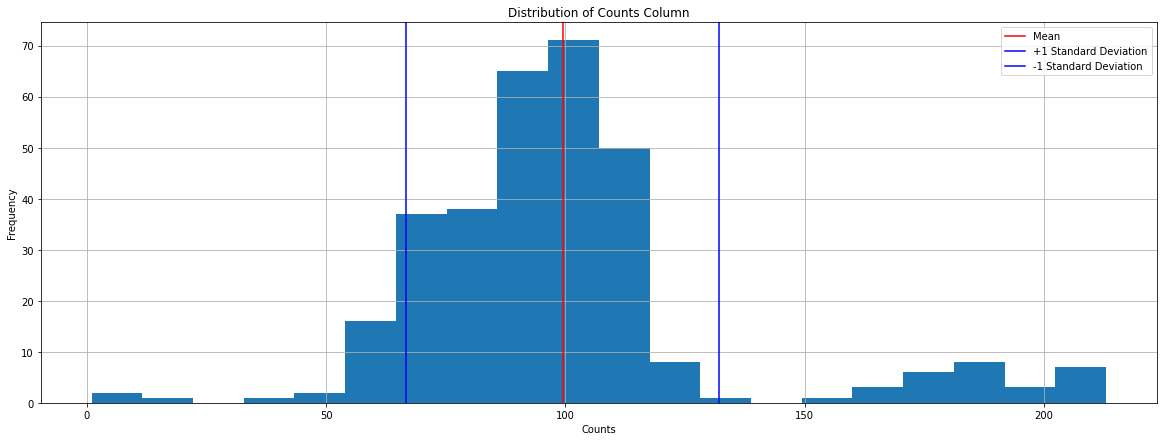

In [727]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))

import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation of the counts column
mean = counts['counts'].mean()
std = counts['counts'].std()

# Plot the histogram of the counts column
counts['counts'].hist(bins=20)

# Add vertical lines to indicate mean and standard deviation
plt.axvline(mean, color='red', label='Mean')
plt.axvline(mean + std, color='blue', label='+1 Standard Deviation')
plt.axvline(mean - std, color='blue', label='-1 Standard Deviation')

# Add title and labels
plt.title('Distribution of Counts Column')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

In [728]:
rides['pickup_day'] = rides['pickup_day'].fillna(0).astype(int)
rides['pickup_month'] = rides['pickup_month'].fillna(0).astype(int)

rides['pickup_day'] = rides['pickup_day'].astype(str)
rides['pickup_month'] = rides['pickup_month'].astype(str)

rides['id'] = rides['pickup_month'] + rides['pickup_day']

rides = rides.drop(['pickup_month','pickup_day'], axis=1)

In [729]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute,id
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,0.173913,0.517241,11
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241,11
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,0.217391,0.517241,11
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,0.304348,0.206897,11
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,0.347826,0.517241,11


In [730]:
rides.shape

(31814, 13)

In [731]:
rides = rides.astype(str)

In [732]:
rides.values[0].astype('float32')

array([ 0.857143,  0.012314,  0.1     ,  0.169343,  0.583333, -0.990825,
        0.848788,  0.837838, -0.990424,  0.848616,  0.173913,  0.517241,
       11.      ], dtype=float32)

Put rides into buckets by date

In [733]:
# Group the rows by the 'id' column
grouped = rides.groupby('id')

# Create a list to store the grouped arrays
day_buckets = []

# Loop through each group
for name, group in grouped:
    # Convert the group to a numpy array
    group_array = group.values.astype(np.float32)
    
    # Append the group array to the list of grouped arrays
    day_buckets.append(group_array)

# Set the display format of the numpy arrays
np.set_printoptions(precision=6, suppress=True)

# Sort the list of grouped arrays by the first column of each array
day_buckets.sort(key=lambda x: x[0][1])


In [734]:
# Do this or when you shuffle below it will shuffle both for some fucking reason, and copy doesn't work.
day_buckets_y = [x.astype(str) for x in day_buckets[1:]]

In [735]:
day_buckets_y[0][0]

array(['0.2857143', '0.0032280714', '0.2', '0.13868614', '0.6805556',
       '-0.990954', '0.8473343', '0.7972973', '-0.99070346', '0.84737885',
       '0.17391305', '0.25862068', '913.0'], dtype='<U32')

In [736]:
def shuffle_np_array(np_array_list):
    for i in range(len(np_array_list)):
        np.random.shuffle(np_array_list[i])
    return np_array_list

day_buckets_X = shuffle_np_array(day_buckets)[1:] # create a shuffled version for X below

Below each 'word' is represented by a vector in the sentence we are trying to predict the order of.

In [737]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# X = []
# y = []
# max_length = 12
# # Convert the input data into a 3D array of shape (num_samples, max_length, num_features)
# for i in day_buckets_X:
#   X.append(pad_sequences(i, maxlen=max_length, dtype='float32', padding='post', truncating='post'))
# for i in day_buckets_y:
#   y.append(pad_sequences(i, maxlen=max_length, dtype='float32', padding='post', truncating='post'))

# space_type 0
# billable_distance 1
# run_name 2
# rider.mediroutes_rider_id 3
# pickup.event_location.zip 4
# pickup.event_location.longitude 5
# pickup.event_location.latitude 6
# dropoff.event_location.zip 7
# dropoff.event_location.longitude 8
# dropoff.event_location.latitude 9
# pickup_hour	pickup_minute 10
# id 11


In [738]:
input = []
target = []
for array in day_buckets_X:
    new_array = np.delete(array, -1, axis=1)
    input.append(new_array.astype('float32'))

count = 0
for array in day_buckets_y:
    new_array = np.delete(array, -1, axis=1)
    target.append(new_array.astype('float32'))


In [739]:
def pad_array(arr):
    padding = np.zeros((1, 12))
    while arr.shape[0] < 125:
        arr = np.concatenate((arr, padding), axis=0)
    return arr
input[0] = pad_array(input[0])
target[0] = pad_array(target[0])

In [740]:
# The error message suggests that the model is expecting 2 inputs, but only 1 input tensor was provided for validation data. 
# To resolve this issue, make sure the input tensors for the validation data match the expected input shape and number of inputs 
# as defined in the model architecture. If the model requires multiple inputs, make sure to pass them in as a list or tuple in 
# the correct order.

def create_validation_set():

  X_val = input[-1].astype('float32')
  X_val = pad_array(X_val)

  y_val = target[-1].astype('float32')
  y_val = pad_array(y_val)

  return X_val, y_val

X_val, y_val = create_validation_set()

In [741]:
input[0]

array([[0.857143, 0.007597, 0.35    , ..., 0.847258, 0.695652, 0.775862],
       [0.285714, 0.006086, 0.95    , ..., 0.850249, 0.565217, 0.517241],
       [0.285714, 0.022562, 0.85    , ..., 0.845252, 0.608696, 0.517241],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [742]:
input_df = pd.DataFrame(input[0], columns=[
'input_space_type',
'input_billable_distance',
'input_run_name',
'input_rider.mediroutes_rider_id',
'input_pickup.event_location.zip',
'input_pickup.event_location.longitude',
'input_pickup.event_location.latitude',
'input_dropoff.event_location.zip',
'input_dropoff.event_location.longitude',
'input_dropoff.event_location.latitude',
'input_pickup_hour',
'input_pickup_minute'
])

target_df = pd.DataFrame(target[0], columns=[
'target_space_type',
'target_billable_distance',
'target_run_name',
'target_rider.mediroutes_rider_id',
'target_pickup.event_location.zip',
'target_pickup.event_location.longitude',
'target_pickup.event_location.latitude',
'target_dropoff.event_location.zip',
'target_dropoff.event_location.longitude',
'target_dropoff.event_location.latitude',
'target_pickup_hour',
'target_pickup_minute'
])

check = pd.concat([input_df, target_df], axis=1)

In [743]:
input[0][24]

array([ 0.857143,  0.003495,  0.95    ,  0.080292,  0.111111, -0.991856,
        0.84872 ,  0.148649, -0.991863,  0.849132,  0.565217,  0.      ])

In [744]:
target[0][0]

array([ 0.285714,  0.003228,  0.2     ,  0.138686,  0.680556, -0.990954,
        0.847334,  0.797297, -0.990703,  0.847379,  0.173913,  0.258621])

In [745]:
check.to_csv('/content/check.csv')

In [746]:
input[0].shape

(125, 12)

In [747]:
target[0].shape

(125, 12)

In [748]:
# Define the input and output shape
input_shape = (125, 12)
output_shape = (125, 12)

Set the day to train on

In [749]:
input = input[0]
target = target[0]
X_val = X_val
y_val = y_val

In [750]:
y_val

array([[0.285714, 0.045571, 0.05    , ..., 0.849885, 0.173913, 0.258621],
       [0.857143, 0.004869, 0.25    , ..., 0.847379, 0.173913, 0.517241],
       [0.857143, 0.012092, 0.3     , ..., 0.848719, 0.173913, 0.775862],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [751]:
# model = keras.models.load_model('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')

In [752]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='mae', patience=5)

In [753]:
input = input.reshape(1, *input.shape)
target = target.reshape(1, *target.shape)
X_val = X_val.reshape(1, *X_val.shape)
y_val = y_val.reshape(1, *y_val.shape)

print(input.shape)
print(target.shape)
print(X_val.shape)
print(y_val.shape)

# Define the encoder
encoder_inputs = keras.layers.Input(shape=input_shape)
encoder = keras.layers.LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = keras.layers.Input(shape=(None, 12))
decoder_lstm = keras.layers.LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add the attention mechanism
attention = keras.layers.Attention()([decoder_outputs, encoder_outputs])
decoder_outputs = keras.layers.Concatenate()([decoder_outputs, attention])

decoder_dense = keras.layers.Dense(12, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error')


(1, 125, 12)
(1, 125, 12)
(1, 125, 12)
(1, 125, 12)


In [754]:
#  validation_data=([X_val, y_val], y_val), the first element of the tuple, [X_val, y_val], are the inputs to the model during validation. The second element of the tuple, y_val, is the expected target output during validation.

# Train the model
history = model.fit([input, target], target, epochs=300, batch_size=16, validation_data=([X_val, y_val], y_val), callbacks=[early_stopping], verbose=2)

Epoch 1/100


1/1 - 5s - loss: 0.3683 - val_loss: 0.3962 - 5s/epoch - 5s/step
Epoch 2/100


1/1 - 0s - loss: 0.3635 - val_loss: 0.3909 - 118ms/epoch - 118ms/step
Epoch 3/100


1/1 - 0s - loss: 0.3587 - val_loss: 0.3856 - 119ms/epoch - 119ms/step
Epoch 4/100


1/1 - 0s - loss: 0.3540 - val_loss: 0.3805 - 121ms/epoch - 121ms/step
Epoch 5/100


1/1 - 0s - loss: 0.3494 - val_loss: 0.3754 - 131ms/epoch - 131ms/step
Epoch 6/100


1/1 - 0s - loss: 0.3448 - val_loss: 0.3703 - 114ms/epoch - 114ms/step
Epoch 7/100


1/1 - 0s - loss: 0.3403 - val_loss: 0.3653 - 116ms/epoch - 116ms/step
Epoch 8/100


1/1 - 0s - loss: 0.3359 - val_loss: 0.3604 - 126ms/epoch - 126ms/step
Epoch 9/100


1/1 - 0s - loss: 0.3315 - val_loss: 0.3555 - 113ms/epoch - 113ms/step
Epoch 10/100


1/1 - 0s - loss: 0.3272 - val_loss: 0.3507 - 124ms/epoch - 124ms/step
Epoch 11/100


1/1 - 0s - loss: 0.3229 - val_loss: 0.3460 - 119ms/epoch - 119ms/step
Epoch 12/100


1/1 - 0s - loss: 0.3186 - val_loss: 0.3413 - 120ms/epoch - 120ms/step
Epoch 13/100


1/1 - 0s - loss: 0.3145 - val_loss: 0.3366 - 127ms/epoch - 127ms/step
Epoch 14/100


1/1 - 0s - loss: 0.3103 - val_loss: 0.3320 - 115ms/epoch - 115ms/step
Epoch 15/100


1/1 - 0s - loss: 0.3062 - val_loss: 0.3275 - 124ms/epoch - 124ms/step
Epoch 16/100


1/1 - 0s - loss: 0.3022 - val_loss: 0.3230 - 117ms/epoch - 117ms/step
Epoch 17/100


1/1 - 0s - loss: 0.2982 - val_loss: 0.3185 - 115ms/epoch - 115ms/step
Epoch 18/100


1/1 - 0s - loss: 0.2943 - val_loss: 0.3141 - 124ms/epoch - 124ms/step
Epoch 19/100


1/1 - 0s - loss: 0.2904 - val_loss: 0.3097 - 111ms/epoch - 111ms/step
Epoch 20/100


1/1 - 0s - loss: 0.2865 - val_loss: 0.3054 - 117ms/epoch - 117ms/step
Epoch 21/100


1/1 - 0s - loss: 0.2827 - val_loss: 0.3010 - 109ms/epoch - 109ms/step
Epoch 22/100


1/1 - 0s - loss: 0.2789 - val_loss: 0.2968 - 122ms/epoch - 122ms/step
Epoch 23/100


1/1 - 0s - loss: 0.2751 - val_loss: 0.2925 - 111ms/epoch - 111ms/step
Epoch 24/100


1/1 - 0s - loss: 0.2714 - val_loss: 0.2883 - 119ms/epoch - 119ms/step
Epoch 25/100


1/1 - 0s - loss: 0.2677 - val_loss: 0.2841 - 115ms/epoch - 115ms/step
Epoch 26/100


1/1 - 0s - loss: 0.2641 - val_loss: 0.2800 - 112ms/epoch - 112ms/step
Epoch 27/100


1/1 - 0s - loss: 0.2605 - val_loss: 0.2758 - 119ms/epoch - 119ms/step
Epoch 28/100


1/1 - 0s - loss: 0.2569 - val_loss: 0.2717 - 120ms/epoch - 120ms/step
Epoch 29/100


1/1 - 0s - loss: 0.2533 - val_loss: 0.2676 - 116ms/epoch - 116ms/step
Epoch 30/100


1/1 - 0s - loss: 0.2497 - val_loss: 0.2635 - 119ms/epoch - 119ms/step
Epoch 31/100


1/1 - 0s - loss: 0.2462 - val_loss: 0.2594 - 134ms/epoch - 134ms/step
Epoch 32/100


1/1 - 0s - loss: 0.2426 - val_loss: 0.2553 - 115ms/epoch - 115ms/step
Epoch 33/100


1/1 - 0s - loss: 0.2391 - val_loss: 0.2513 - 115ms/epoch - 115ms/step
Epoch 34/100


1/1 - 0s - loss: 0.2356 - val_loss: 0.2472 - 114ms/epoch - 114ms/step
Epoch 35/100


1/1 - 0s - loss: 0.2321 - val_loss: 0.2431 - 131ms/epoch - 131ms/step
Epoch 36/100


1/1 - 0s - loss: 0.2286 - val_loss: 0.2390 - 110ms/epoch - 110ms/step
Epoch 37/100


1/1 - 0s - loss: 0.2252 - val_loss: 0.2349 - 123ms/epoch - 123ms/step
Epoch 38/100


1/1 - 0s - loss: 0.2217 - val_loss: 0.2308 - 118ms/epoch - 118ms/step
Epoch 39/100


1/1 - 0s - loss: 0.2182 - val_loss: 0.2267 - 119ms/epoch - 119ms/step
Epoch 40/100


1/1 - 0s - loss: 0.2147 - val_loss: 0.2225 - 118ms/epoch - 118ms/step
Epoch 41/100


1/1 - 0s - loss: 0.2111 - val_loss: 0.2183 - 117ms/epoch - 117ms/step
Epoch 42/100


1/1 - 0s - loss: 0.2076 - val_loss: 0.2141 - 113ms/epoch - 113ms/step
Epoch 43/100


1/1 - 0s - loss: 0.2041 - val_loss: 0.2099 - 123ms/epoch - 123ms/step
Epoch 44/100


1/1 - 0s - loss: 0.2005 - val_loss: 0.2056 - 118ms/epoch - 118ms/step
Epoch 45/100


1/1 - 0s - loss: 0.1969 - val_loss: 0.2013 - 132ms/epoch - 132ms/step
Epoch 46/100


1/1 - 0s - loss: 0.1933 - val_loss: 0.1970 - 115ms/epoch - 115ms/step
Epoch 47/100


1/1 - 0s - loss: 0.1896 - val_loss: 0.1926 - 115ms/epoch - 115ms/step
Epoch 48/100


1/1 - 0s - loss: 0.1859 - val_loss: 0.1881 - 131ms/epoch - 131ms/step
Epoch 49/100


1/1 - 0s - loss: 0.1821 - val_loss: 0.1837 - 117ms/epoch - 117ms/step
Epoch 50/100


1/1 - 0s - loss: 0.1783 - val_loss: 0.1792 - 116ms/epoch - 116ms/step
Epoch 51/100


1/1 - 0s - loss: 0.1745 - val_loss: 0.1746 - 126ms/epoch - 126ms/step
Epoch 52/100


1/1 - 0s - loss: 0.1706 - val_loss: 0.1700 - 118ms/epoch - 118ms/step
Epoch 53/100


1/1 - 0s - loss: 0.1666 - val_loss: 0.1654 - 117ms/epoch - 117ms/step
Epoch 54/100


1/1 - 0s - loss: 0.1626 - val_loss: 0.1608 - 117ms/epoch - 117ms/step
Epoch 55/100


1/1 - 0s - loss: 0.1586 - val_loss: 0.1562 - 113ms/epoch - 113ms/step
Epoch 56/100


1/1 - 0s - loss: 0.1545 - val_loss: 0.1517 - 111ms/epoch - 111ms/step
Epoch 57/100


1/1 - 0s - loss: 0.1504 - val_loss: 0.1471 - 114ms/epoch - 114ms/step
Epoch 58/100


1/1 - 0s - loss: 0.1463 - val_loss: 0.1427 - 114ms/epoch - 114ms/step
Epoch 59/100


1/1 - 0s - loss: 0.1421 - val_loss: 0.1383 - 112ms/epoch - 112ms/step
Epoch 60/100


1/1 - 0s - loss: 0.1380 - val_loss: 0.1341 - 133ms/epoch - 133ms/step
Epoch 61/100


1/1 - 0s - loss: 0.1340 - val_loss: 0.1301 - 119ms/epoch - 119ms/step
Epoch 62/100


1/1 - 0s - loss: 0.1301 - val_loss: 0.1262 - 116ms/epoch - 116ms/step
Epoch 63/100


1/1 - 0s - loss: 0.1263 - val_loss: 0.1227 - 110ms/epoch - 110ms/step
Epoch 64/100


1/1 - 0s - loss: 0.1227 - val_loss: 0.1194 - 116ms/epoch - 116ms/step
Epoch 65/100


1/1 - 0s - loss: 0.1193 - val_loss: 0.1164 - 118ms/epoch - 118ms/step
Epoch 66/100


1/1 - 0s - loss: 0.1162 - val_loss: 0.1138 - 116ms/epoch - 116ms/step
Epoch 67/100


1/1 - 0s - loss: 0.1135 - val_loss: 0.1114 - 118ms/epoch - 118ms/step
Epoch 68/100


1/1 - 0s - loss: 0.1110 - val_loss: 0.1093 - 131ms/epoch - 131ms/step
Epoch 69/100


1/1 - 0s - loss: 0.1088 - val_loss: 0.1074 - 110ms/epoch - 110ms/step
Epoch 70/100


1/1 - 0s - loss: 0.1068 - val_loss: 0.1055 - 126ms/epoch - 126ms/step
Epoch 71/100


1/1 - 0s - loss: 0.1050 - val_loss: 0.1037 - 115ms/epoch - 115ms/step
Epoch 72/100


1/1 - 0s - loss: 0.1032 - val_loss: 0.1018 - 118ms/epoch - 118ms/step
Epoch 73/100


1/1 - 0s - loss: 0.1015 - val_loss: 0.0998 - 113ms/epoch - 113ms/step
Epoch 74/100


1/1 - 0s - loss: 0.0997 - val_loss: 0.0977 - 115ms/epoch - 115ms/step
Epoch 75/100


1/1 - 0s - loss: 0.0979 - val_loss: 0.0956 - 127ms/epoch - 127ms/step
Epoch 76/100


1/1 - 0s - loss: 0.0960 - val_loss: 0.0934 - 125ms/epoch - 125ms/step
Epoch 77/100


1/1 - 0s - loss: 0.0941 - val_loss: 0.0912 - 114ms/epoch - 114ms/step
Epoch 78/100


1/1 - 0s - loss: 0.0923 - val_loss: 0.0891 - 127ms/epoch - 127ms/step
Epoch 79/100


1/1 - 0s - loss: 0.0906 - val_loss: 0.0871 - 124ms/epoch - 124ms/step
Epoch 80/100


1/1 - 0s - loss: 0.0890 - val_loss: 0.0852 - 124ms/epoch - 124ms/step
Epoch 81/100


1/1 - 0s - loss: 0.0876 - val_loss: 0.0835 - 118ms/epoch - 118ms/step
Epoch 82/100


1/1 - 0s - loss: 0.0862 - val_loss: 0.0819 - 109ms/epoch - 109ms/step
Epoch 83/100


1/1 - 0s - loss: 0.0850 - val_loss: 0.0805 - 119ms/epoch - 119ms/step
Epoch 84/100


1/1 - 0s - loss: 0.0839 - val_loss: 0.0792 - 121ms/epoch - 121ms/step
Epoch 85/100


1/1 - 0s - loss: 0.0829 - val_loss: 0.0780 - 127ms/epoch - 127ms/step
Epoch 86/100


1/1 - 0s - loss: 0.0820 - val_loss: 0.0770 - 119ms/epoch - 119ms/step
Epoch 87/100


1/1 - 0s - loss: 0.0811 - val_loss: 0.0760 - 120ms/epoch - 120ms/step
Epoch 88/100


1/1 - 0s - loss: 0.0803 - val_loss: 0.0751 - 115ms/epoch - 115ms/step
Epoch 89/100


1/1 - 0s - loss: 0.0795 - val_loss: 0.0743 - 116ms/epoch - 116ms/step
Epoch 90/100


1/1 - 0s - loss: 0.0787 - val_loss: 0.0736 - 117ms/epoch - 117ms/step
Epoch 91/100


1/1 - 0s - loss: 0.0779 - val_loss: 0.0729 - 116ms/epoch - 116ms/step
Epoch 92/100


1/1 - 0s - loss: 0.0772 - val_loss: 0.0723 - 117ms/epoch - 117ms/step
Epoch 93/100


1/1 - 0s - loss: 0.0765 - val_loss: 0.0718 - 131ms/epoch - 131ms/step
Epoch 94/100


1/1 - 0s - loss: 0.0758 - val_loss: 0.0714 - 114ms/epoch - 114ms/step
Epoch 95/100


1/1 - 0s - loss: 0.0753 - val_loss: 0.0710 - 119ms/epoch - 119ms/step
Epoch 96/100


1/1 - 0s - loss: 0.0747 - val_loss: 0.0707 - 115ms/epoch - 115ms/step
Epoch 97/100


1/1 - 0s - loss: 0.0742 - val_loss: 0.0703 - 127ms/epoch - 127ms/step
Epoch 98/100


1/1 - 0s - loss: 0.0738 - val_loss: 0.0700 - 116ms/epoch - 116ms/step
Epoch 99/100


1/1 - 0s - loss: 0.0733 - val_loss: 0.0697 - 116ms/epoch - 116ms/step
Epoch 100/100


1/1 - 0s - loss: 0.0729 - val_loss: 0.0694 - 125ms/epoch - 125ms/step


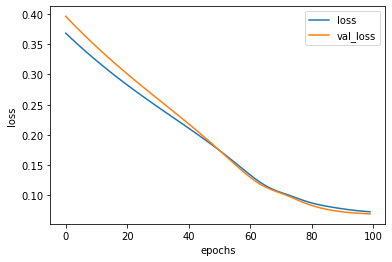

In [755]:
# Plot history (also known as a loss curve)
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

predict the vehicle for a ride by including the vehicle information in the input and target data and leaving a placeholder (e.g. zero) in place of the vehicle information at the time of prediction

In [756]:
pred = model.predict([input, target])

1/1 [==============================] - 1s 860ms/step


In [757]:
pred[0][0]

array([ 0.385121,  0.20062 ,  0.097768, -0.028536,  0.080793, -0.450963,
        0.283011,  0.231442, -0.393531,  0.317179,  0.171867,  0.092369],
      dtype=float32)

In [758]:
input[0][0]

array([ 0.857143,  0.007597,  0.35    ,  0.051095,  0.666667, -0.989978,
        0.848206,  0.702703, -0.989809,  0.847258,  0.695652,  0.775862])

Look at a specific day

In [759]:
pred_report = pd.DataFrame(pred[0], columns=[
'pred_space_type',
'pred_billable_distance',
'pred_run_name',
'pred_rider.mediroutes_rider_id',
'pred_pickup.event_location.zip',
'pred_pickup.event_location.longitude',
'pred_pickup.event_location.latitude',
'pred_dropoff.event_location.zip',
'pred_dropoff.event_location.longitude',
'pred_dropoff.event_location.latitude',
'pred_pickup_hour',
'pred_pickup_minute'
])

In [760]:
pred_report.head()

,pred_space_type,pred_billable_distance,pred_run_name,pred_rider.mediroutes_rider_id,pred_pickup.event_location.zip,pred_pickup.event_location.longitude,pred_pickup.event_location.latitude,pred_dropoff.event_location.zip,pred_dropoff.event_location.longitude,pred_dropoff.event_location.latitude,pred_pickup_hour,pred_pickup_minute
0,0.385121,0.200620,0.097768,-0.028536,0.080793,-0.450963,0.283011,0.231442,-0.393531,0.317179,0.171867,0.092369
1,0.408647,0.110499,0.118090,-0.032597,0.160766,-0.441736,0.396322,0.252114,-0.462327,0.377154,0.221748,0.099082
2,0.418570,0.056199,0.158286,-0.018290,0.252188,-0.444966,0.478344,0.249310,-0.500038,0.426197,0.246697,0.106495
3,0.439595,0.013114,0.185103,0.017480,0.315645,-0.458012,0.550783,0.280956,-0.513371,0.458697,0.256616,0.129534
4,0.449556,-0.003826,0.230327,0.025810,0.396709,-0.492380,0.597831,0.299365,-0.552316,0.522284,0.266864,0.130089


In [761]:
target_report = pd.DataFrame(target[0], columns=[
  'target_space_type',
  'target_billable_distance',
  'target_run_name',
  'target_rider.mediroutes_rider_id',
  'target_pickup.event_location.zip',
  'target_pickup.event_location.longitude',
  'target_pickup.event_location.latitude',
  'target_dropoff.event_location.zip',
  'target_dropoff.event_location.longitude',
  'target_dropoff.event_location.latitude',
  'target_pickup_hour',
  'target_pickup_minute'
])

In [762]:
target_report.head()

,target_space_type,target_billable_distance,target_run_name,target_rider.mediroutes_rider_id,target_pickup.event_location.zip,target_pickup.event_location.longitude,target_pickup.event_location.latitude,target_dropoff.event_location.zip,target_dropoff.event_location.longitude,target_dropoff.event_location.latitude,target_pickup_hour,target_pickup_minute
0,0.285714,0.003228,0.20,0.138686,0.680556,-0.990954,0.847334,0.797297,-0.990703,0.847379,0.173913,0.258621
1,0.857143,0.012053,0.20,0.061314,0.472222,-0.991429,0.847318,0.121622,-0.991856,0.848719,0.173913,0.775862
2,0.857143,0.006394,0.20,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241
3,0.285714,0.011718,0.20,0.102190,0.458333,-0.990903,0.846275,0.662162,-0.990333,0.845598,0.217391,0.775862
4,0.857143,0.017380,0.25,0.119708,0.916667,-0.990598,0.849091,0.797297,-0.990656,0.847092,0.217391,0.000000


In [763]:
f = pd.concat([pred_report, target_report], axis=1)

In [764]:
f.head()

,pred_space_type,pred_billable_distance,pred_run_name,pred_rider.mediroutes_rider_id,pred_pickup.event_location.zip,pred_pickup.event_location.longitude,pred_pickup.event_location.latitude,pred_dropoff.event_location.zip,pred_dropoff.event_location.longitude,pred_dropoff.event_location.latitude,...,target_run_name,target_rider.mediroutes_rider_id,target_pickup.event_location.zip,target_pickup.event_location.longitude,target_pickup.event_location.latitude,target_dropoff.event_location.zip,target_dropoff.event_location.longitude,target_dropoff.event_location.latitude,target_pickup_hour,target_pickup_minute
0,0.385121,0.200620,0.097768,-0.028536,0.080793,-0.450963,0.283011,0.231442,-0.393531,0.317179,...,0.20,0.138686,0.680556,-0.990954,0.847334,0.797297,-0.990703,0.847379,0.173913,0.258621
1,0.408647,0.110499,0.118090,-0.032597,0.160766,-0.441736,0.396322,0.252114,-0.462327,0.377154,...,0.20,0.061314,0.472222,-0.991429,0.847318,0.121622,-0.991856,0.848719,0.173913,0.775862
2,0.418570,0.056199,0.158286,-0.018290,0.252188,-0.444966,0.478344,0.249310,-0.500038,0.426197,...,0.20,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241
3,0.439595,0.013114,0.185103,0.017480,0.315645,-0.458012,0.550783,0.280956,-0.513371,0.458697,...,0.20,0.102190,0.458333,-0.990903,0.846275,0.662162,-0.990333,0.845598,0.217391,0.775862
4,0.449556,-0.003826,0.230327,0.025810,0.396709,-0.492380,0.597831,0.299365,-0.552316,0.522284,...,0.25,0.119708,0.916667,-0.990598,0.849091,0.797297,-0.990656,0.847092,0.217391,0.000000


In [765]:
f.to_csv('/content/comparison.csv')

In [766]:
pred_report.iloc[:,:2]

,pred_space_type,pred_billable_distance
0,0.385121,0.200620
1,0.408647,0.110499
2,0.418570,0.056199
3,0.439595,0.013114
4,0.449556,-0.003826
...,...,...
120,0.341264,0.281943
121,0.341050,0.281981
122,0.340878,0.282011
123,0.340741,0.282035


In [767]:
target_report.iloc[:,:2]

,target_space_type,target_billable_distance
0,0.285714,0.003228
1,0.857143,0.012053
2,0.857143,0.006394
3,0.285714,0.011718
4,0.857143,0.017380
...,...,...
120,0.000000,0.000000
121,0.000000,0.000000
122,0.000000,0.000000
123,0.000000,0.000000
